In [5]:
# Q1: Load Iris and prepare dataset (only 2 features: sepal length, sepal width)
# - This cell loads the dataset, selects only the first two features (sepal length/width),
#   and creates a stratified train/test split for reproducible results.
# - We keep the original feature names for plotting/labels.

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load iris
iris = load_iris()
X_full = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Use only first two features: sepal length (cm), sepal width (cm)
X = X_full[:, :2]
selected_feature_names = feature_names[:2]

# Stratified split to preserve class proportions; random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Using features:", selected_feature_names)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class distribution in train:", dict(zip(*np.unique(y_train, return_counts=True))))


Using features: ['sepal length (cm)', 'sepal width (cm)']
Train shape: (105, 2) Test shape: (45, 2)
Class distribution in train: {np.int64(0): np.int64(35), np.int64(1): np.int64(35), np.int64(2): np.int64(35)}


In [6]:
# Q2: Train kNN models with k = 1, 3, 5, 10
# - We use a Pipeline with StandardScaler + KNeighborsClassifier to ensure fair distance computations.
# - After training we print train and test accuracy for each k.
# - Scaling is recommended for kNN since it is distance-based.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

ks = [1, 3, 5, 10]
models = {}  # store fitted pipelines keyed by k
results = []

for k in ks:
    # Pipeline ensures scaling is applied the same way at train and predict time
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train, y_train)
    models[k] = pipe
    
    # Evaluate
    train_acc = accuracy_score(y_train, pipe.predict(X_train))
    test_acc  = accuracy_score(y_test,  pipe.predict(X_test))
    results.append({"k": k, "train_accuracy": train_acc, "test_accuracy": test_acc})
    print(f"k={k} -> train_acc = {train_acc:.4f}, test_acc = {test_acc:.4f}")

# show a small table
import pandas as pd
print("\nSummary:")
print(pd.DataFrame(results).set_index("k"))


k=1 -> train_acc = 0.9429, test_acc = 0.7333
k=3 -> train_acc = 0.8476, test_acc = 0.6889
k=5 -> train_acc = 0.8571, test_acc = 0.6444
k=10 -> train_acc = 0.8000, test_acc = 0.7556

Summary:
    train_accuracy  test_accuracy
k                                
1         0.942857       0.733333
3         0.847619       0.688889
5         0.857143       0.644444
10        0.800000       0.755556


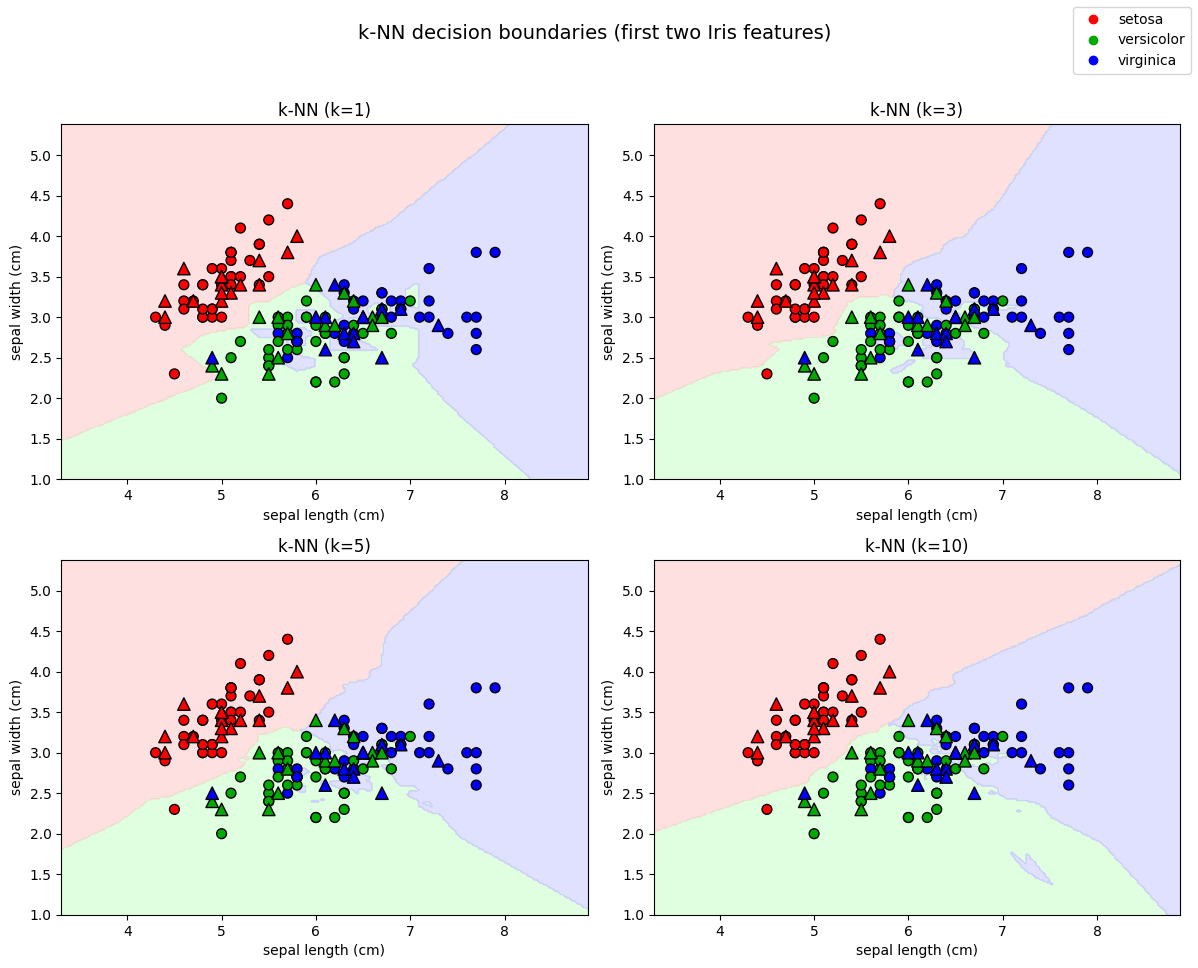

In [7]:
# Q3: Plot decision boundaries for each k (1,3,5,10)
# - Retrains/uses the pipelines in `models` that include scaling.
# - Produces a 2x2 grid of plots (one subplot per k).
# - Training points are shown; decision regions are colored by predicted class.
# - Test points are plotted with edgecolor='k' and slightly larger marker to be visible.

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create mesh grid covering the feature space
h = 0.02  # mesh step size
x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Color maps
cmap_light = ListedColormap(['#FFCCCC', '#CCFFCC', '#CCCCFF'])
cmap_points = ListedColormap(['#FF0000', '#00AA00', '#0000FF'])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, k in zip(axes, ks):
    pipe = models[k]  # pipeline containing scaler + knn
    # Predict on the grid (the pipeline applies scaling first)
    Z = pipe.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot decision region
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    
    # Plot training points
    scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap_points, edgecolor='k', s=50, label='train')
    # Overlay test points (different marker)
    ax.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cmap_points, marker='^', edgecolor='k', s=80, label='test')
    
    ax.set_title(f"k-NN (k={k})")
    ax.set_xlabel(selected_feature_names[0])
    ax.set_ylabel(selected_feature_names[1])
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

# Shared legend
handles, labels = scatter.legend_elements()
fig.legend(handles, target_names, loc='upper right')
plt.suptitle("k-NN decision boundaries (first two Iris features)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
# Q4: 
"""
Discussion: How k (number of neighbors) changes k-NN decision boundaries 

Short summary:
- k=1: Very flexible, detailed boundaries. Each training point "casts a vote" only for itself. The decision
  boundary is jagged and follows the training points closely. This yields low bias (fits training data well)
  but high variance (sensitive to noise / outliers). Overfitting risk is highest at very small k.

- k=3: Boundaries become smoother. Local neighborhoods now require agreement among 3 neighbors, so a single
  mislabeled point has less influence. Variance decreases and bias increases slightly.

- k=5: Even smoother boundaries. Decision regions are more regular and generalize better on average; small
  islands of a different class are removed. This usually reduces variance further but may increase bias if k is too large.

- k=10: Much smoother, broader regions dominated by the global class structure. The model is more stable to
  noise (low variance) but may underfit if k is too large relative to dataset size (higher bias).

Practical interpretation:
- As k increases: complexity of the decision boundary decreases (smoother), variance reduces, bias increases.
- There is a bias-variance tradeoff: small k -> low bias, high variance; large k -> high bias, low variance.
- Choose k by cross-validation 

"""


'\nDiscussion: How k (number of neighbors) changes k-NN decision boundaries \n\nShort summary:\n- k=1: Very flexible, detailed boundaries. Each training point "casts a vote" only for itself. The decision\n  boundary is jagged and follows the training points closely. This yields low bias (fits training data well)\n  but high variance (sensitive to noise / outliers). Overfitting risk is highest at very small k.\n\n- k=3: Boundaries become smoother. Local neighborhoods now require agreement among 3 neighbors, so a single\n  mislabeled point has less influence. Variance decreases and bias increases slightly.\n\n- k=5: Even smoother boundaries. Decision regions are more regular and generalize better on average; small\n  islands of a different class are removed. This usually reduces variance further but may increase bias if k is too large.\n\n- k=10: Much smoother, broader regions dominated by the global class structure. The model is more stable to\n  noise (low variance) but may underfit if